In [10]:
import warnings
import os

# Our numerical workhorse
import numpy as np
import scipy

# Image processing tools
import skimage
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.feature

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.filterwarnings('ignore')

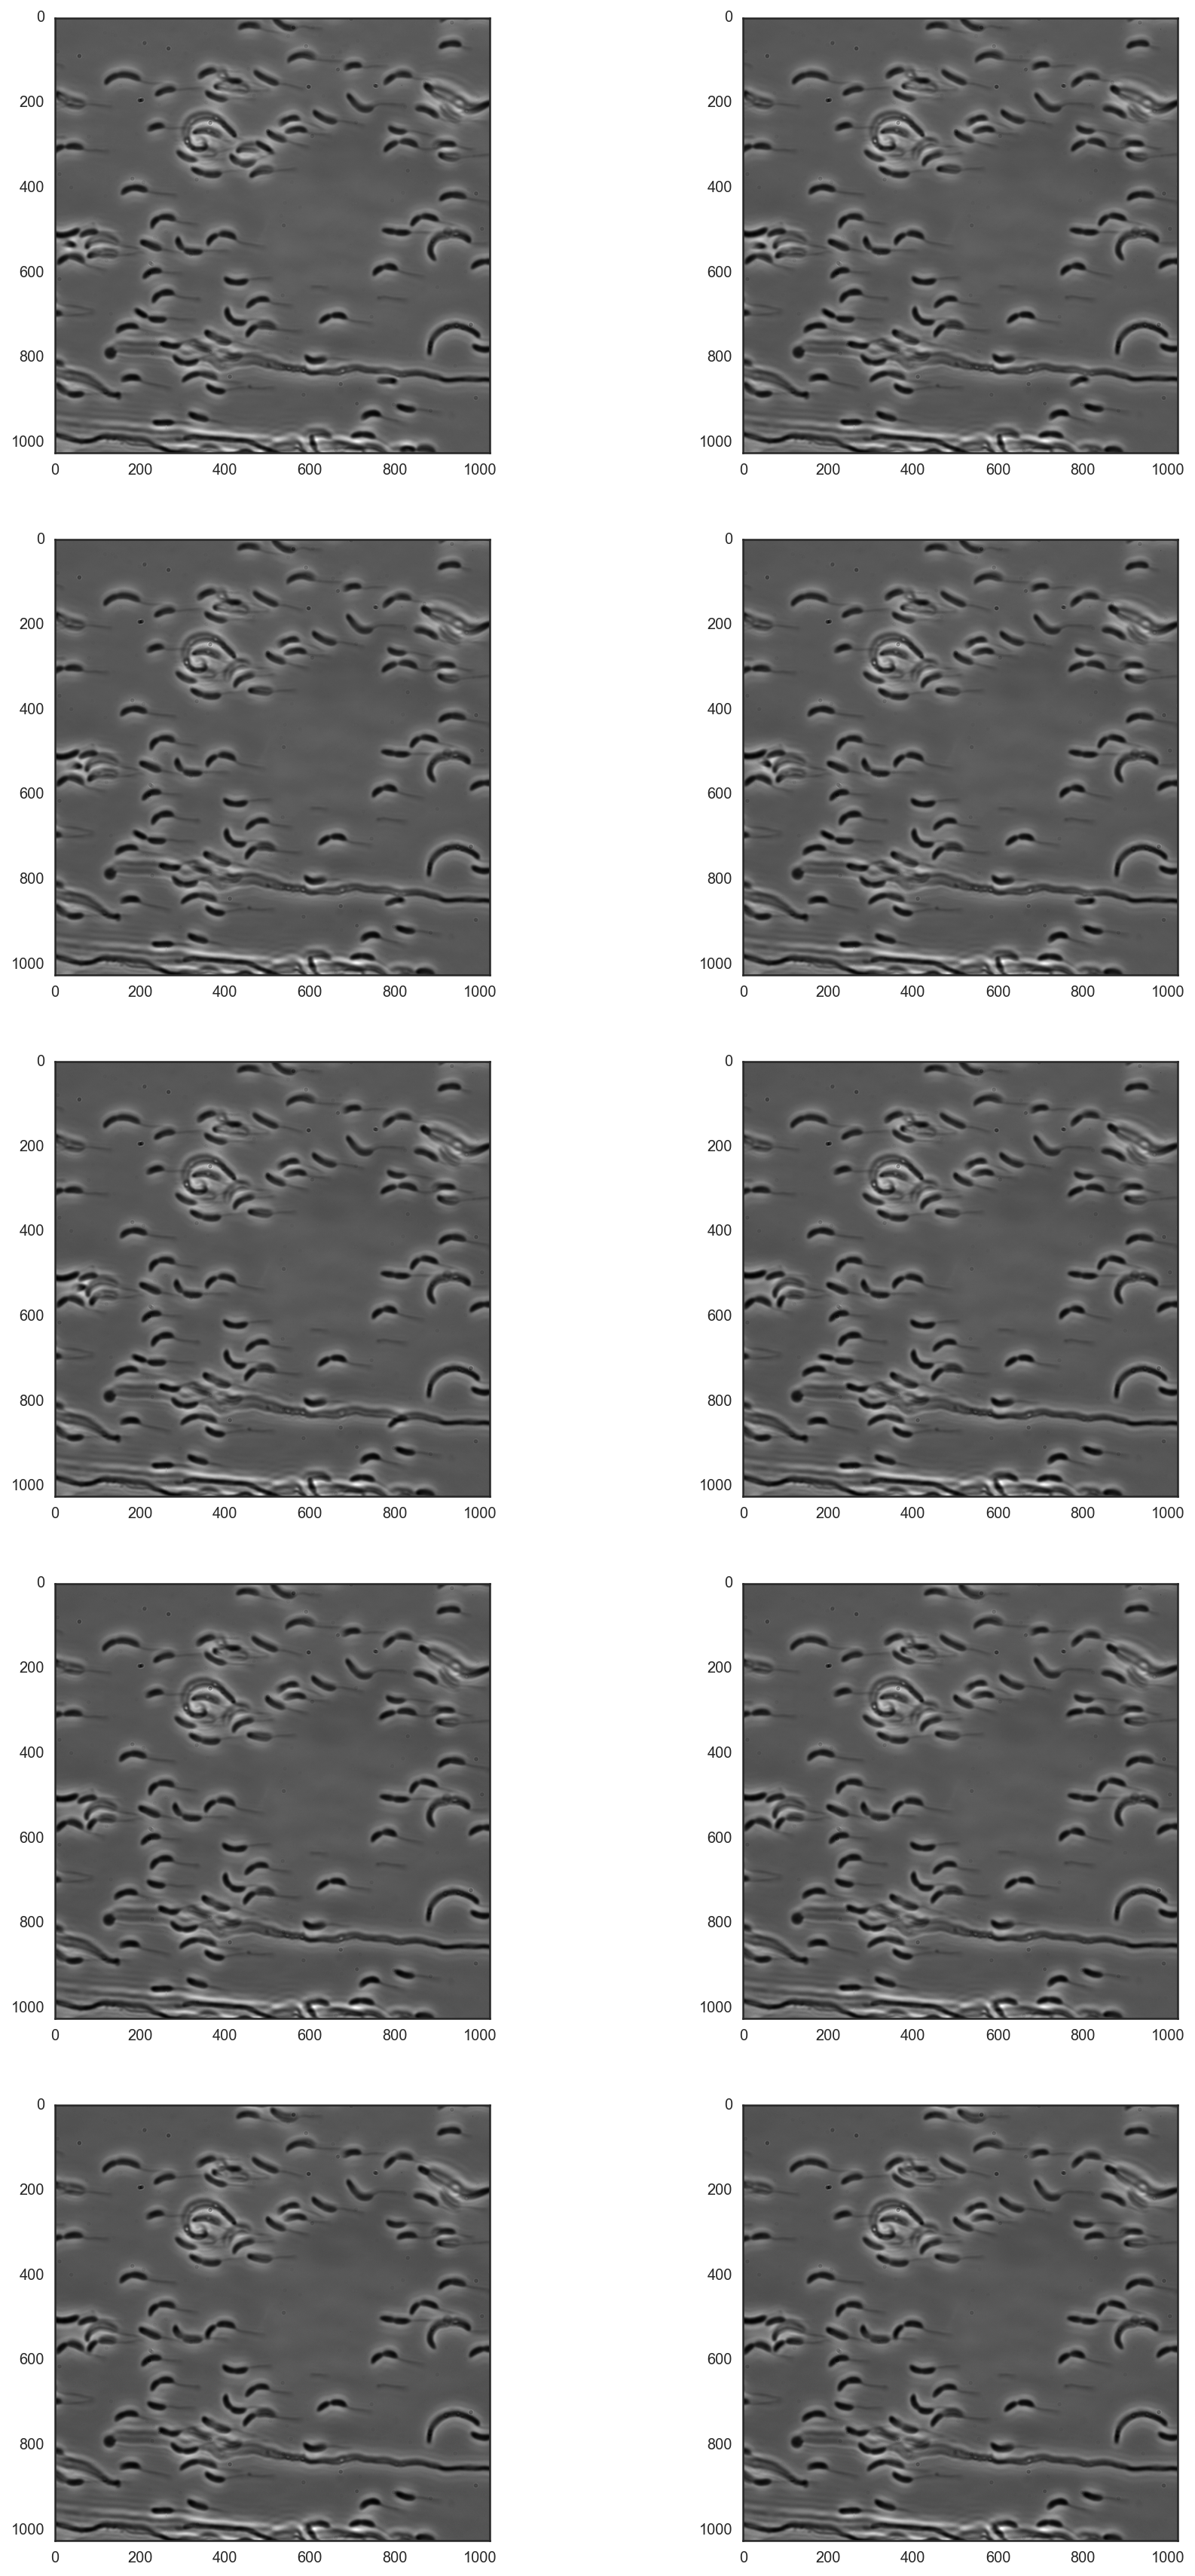

In [23]:
image_dir = '/Users/elenaperry/Dropbox/Caltech/bebi103/hw8_iyer-biswas_et_al\
/sequential_full_field/phase0300'

im_list = []
im_float_list = []
f = plt.figure(figsize=(15,30))

for i in range(10):
    im_list.append(image_dir + str(i) + '.tif')

    im = skimage.io.imread(im_list[i])
    im_float_list.append((im.astype(float) - im.min()) / (im.max() - im.min()))
    
for i in range(10):
    with sns.axes_style('white'):
        plt.subplot(5,2,i+1)
        plt.imshow(im_float_list[i], cmap=plt.cm.gray)

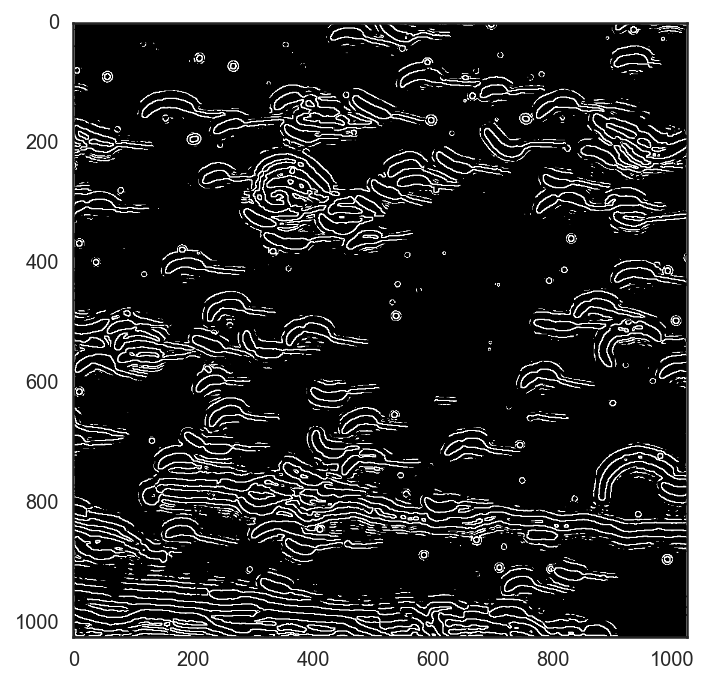

In [32]:
# Compute LoG
im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float_list[0], 2.0)

def zero_crossing_filter(im, thresh):
    """
    Returns image with 1 if there is a zero crossing and 0 otherwise.
    
    thresh is the the minimal value of the gradient, as computed by Sobel
    filter, at crossing to count as a crossing.
    """
    # Square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)
    
    # Compute gradients using Sobel filter
    im_grad = skimage.filters.sobel(im)
    
    # Return edges
    return (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0))) \
                & (im_grad >= thresh)

# Find zero-crossings
im_edge = zero_crossing_filter(im_LoG, 0.001)

# Show result
with sns.axes_style('white'):
    plt.imshow(im_edge, cmap=plt.cm.gray)

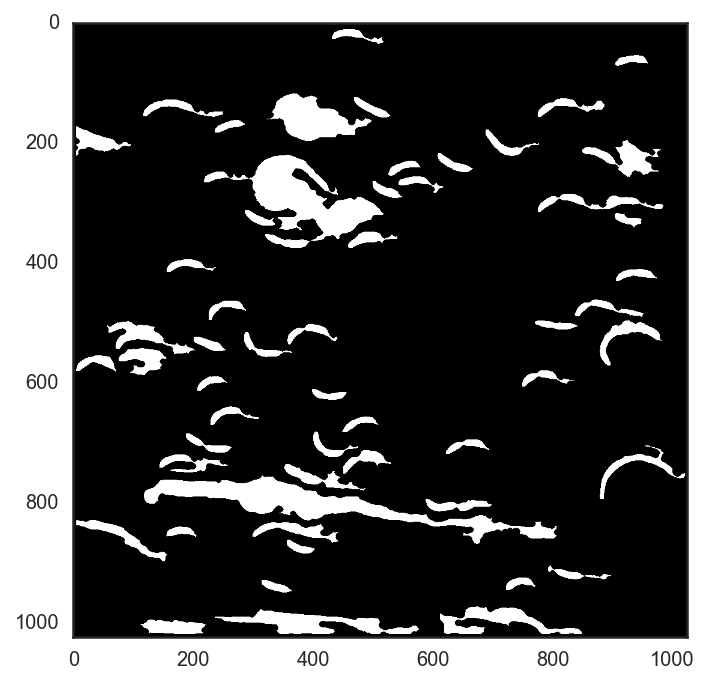

In [57]:
# Structuring element is radius 2 disk
selem = skimage.morphology.disk(2)

# Close binary image
im_bw_close = skimage.morphology.binary_closing(im_edge, selem)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw_close, min_size=500)

# Fill holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_bw)

# Structuring element is radius 3 disk
selem = skimage.morphology.disk(3)

# Erode binary image again
im_bw_eroded = skimage.morphology.erosion(im_bw, selem)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw_eroded, min_size=500)

# Show result
with sns.axes_style('white'):
    plt.imshow(im_bw, cmap=plt.cm.gray)